In [1]:
import itk
import matplotlib.pyplot as plt
import numpy as np


In [2]:
def display_images(original_image, processed_image):

    original_image_array = itk.array_from_image(original_image)
    processed_image_array = itk.array_from_image(processed_image)
    
    # Convert the arrays to uint8 if necessary
    original_image_array = original_image_array.astype(np.uint8)
    processed_image_array = processed_image_array.astype(np.uint8)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(original_image_array, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(processed_image_array, cmap='gray')
    axes[1].set_title('Filtered Image')
    axes[1].axis('off')

    plt.show()

# Blurring

## Discrete Gaussian

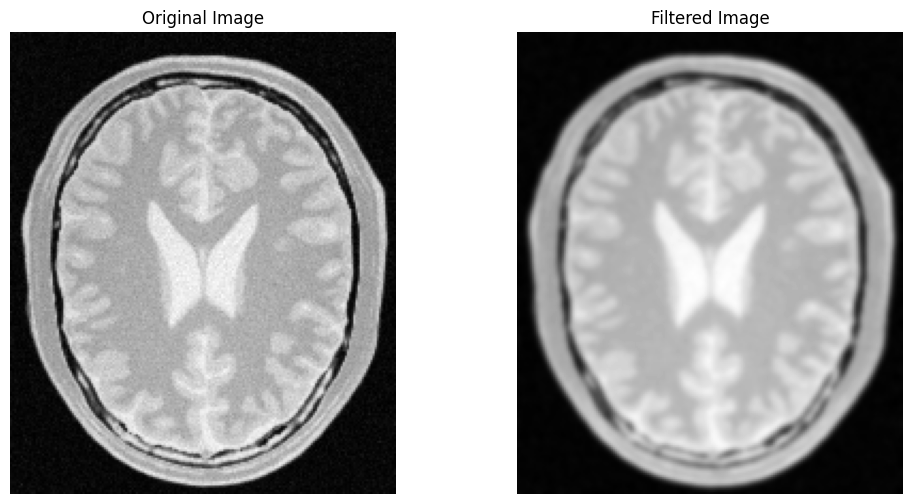

In [8]:

input_image = "images/BrainProtonDensitySlice.png"

variance = 2
maxkernelwidth = 3

InputPixelType = itk.F
OutputPixelType = itk.F
Dimension = 2

InputImageType = itk.Image[InputPixelType, Dimension]
OutputImageType = itk.Image[OutputPixelType, Dimension]

reader = itk.ImageFileReader[InputImageType].New()
reader.SetFileName(input_image)

filter = itk.DiscreteGaussianImageFilter.New(reader)
filter.SetVariance(variance)
filter.SetMaximumKernelWidth(maxkernelwidth)

filter.Update()

display_images(reader.GetOutput(), filter.GetOutput())

In [13]:
supported_types = itk.DiscreteGaussianImageFilter.GetTypes()
print(supported_types)

<itkTemplate itk::DiscreteGaussianImageFilter>
Options:
  [<class 'itk.itkImagePython.itkImageD2'>, <class 'itk.itkImagePython.itkImageD2'>]
  [<class 'itk.itkImagePython.itkImageD3'>, <class 'itk.itkImagePython.itkImageD3'>]
  [<class 'itk.itkImagePython.itkImageD4'>, <class 'itk.itkImagePython.itkImageD4'>]
  [<class 'itk.itkImagePython.itkImageF2'>, <class 'itk.itkImagePython.itkImageF2'>]
  [<class 'itk.itkImagePython.itkImageF3'>, <class 'itk.itkImagePython.itkImageF3'>]
  [<class 'itk.itkImagePython.itkImageF4'>, <class 'itk.itkImagePython.itkImageF4'>]
  [<class 'itk.itkImagePython.itkImageSS2'>, <class 'itk.itkImagePython.itkImageSS2'>]
  [<class 'itk.itkImagePython.itkImageSS3'>, <class 'itk.itkImagePython.itkImageSS3'>]
  [<class 'itk.itkImagePython.itkImageSS4'>, <class 'itk.itkImagePython.itkImageSS4'>]
  [<class 'itk.itkImagePython.itkImageUC2'>, <class 'itk.itkImagePython.itkImageUC2'>]
  [<class 'itk.itkImagePython.itkImageUC3'>, <class 'itk.itkImagePython.itkImageUC3'>]

## Binomial Blurring

This computes a nearest neighbor average along each dimension. The process is repeated a number of times, as specified by the user. In principle, after a large number of iterations the result will approach the convolution with a Gaussian.

The "nearest neighbor" principle here refers to the process of averaging each pixel with its closest neighboring pixels (left and right in 1D, or adjacent pixels in 2D). This simple averaging step is repeated iteratively, with each iteration further smoothing the image.

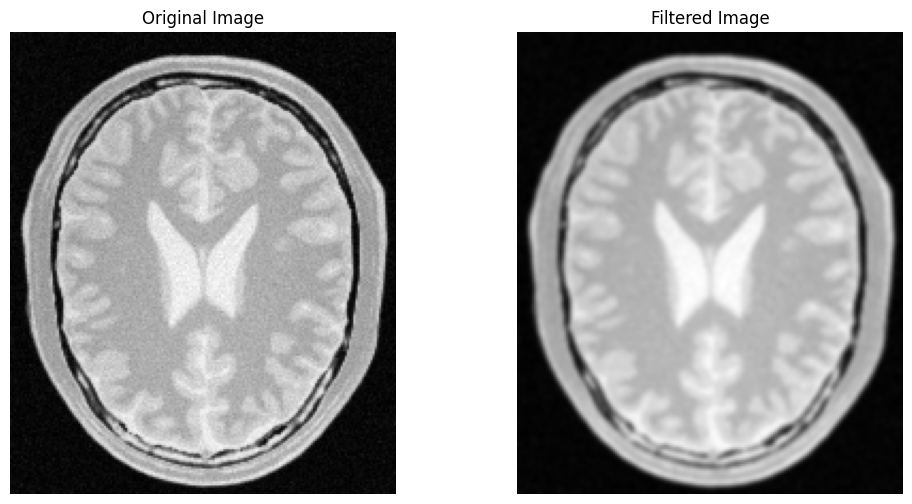

In [14]:
no_of_repetitions = 2

InputPixelType = itk.F
OutputPixelType = itk.F
Dimension = 2

InputImageType = itk.Image[InputPixelType, Dimension]
OutputImageType = itk.Image[OutputPixelType, Dimension]

reader = itk.ImageFileReader[InputImageType].New()
reader.SetFileName(input_image)

# Create and setup a Gaussian filter
binomial_blur_filter = itk.BinomialBlurImageFilter[InputImageType, OutputImageType].New()
binomial_blur_filter.SetInput(reader.GetOutput())
binomial_blur_filter.SetRepetitions(no_of_repetitions)

binomial_blur_filter.Update()

display_images(reader.GetOutput(), binomial_blur_filter.GetOutput())

## Recursive Gaussian IIR

Approximates convolution with Gaussian and its derivatives by IIR filters.

Lesser computational time.

Two normalization techniques to preserve maximum value or integral. Not used here, since we scale anyways to display.


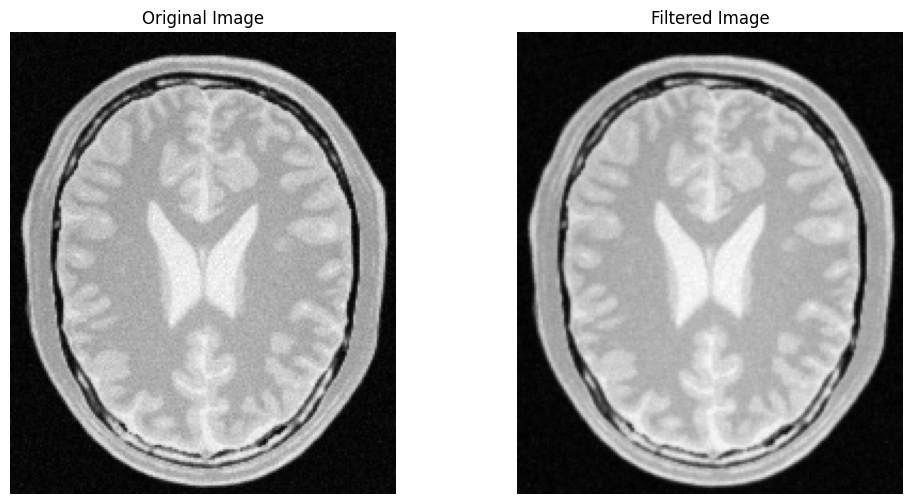

In [17]:
sigma = 0.5

InputPixelType = itk.F
OutputPixelType = itk.F
Dimension = 2

InputImageType = itk.Image[InputPixelType, Dimension]
OutputImageType = itk.Image[OutputPixelType, Dimension]

reader = itk.ImageFileReader[InputImageType].New()
reader.SetFileName(input_image)

FilterType = itk.RecursiveGaussianImageFilter[InputImageType, OutputImageType]

filterX = FilterType.New()
filterY = FilterType.New()

filterX.SetDirection(0)
filterY.SetDirection(1) 

filterX.SetOrder(0)
filterY.SetOrder(0)

filterX.SetNormalizeAcrossScale(False)
filterY.SetNormalizeAcrossScale(False)

filterX.SetInput(reader.GetOutput())
filterY.SetInput(filterX.GetOutput())  

filterX.SetSigma(sigma)
filterY.SetSigma(sigma) 

filterX.Update()
filterY.Update()

display_images(reader.GetOutput(), filterY.GetOutput())

# Anisotropic Diffusion

 The drawback of image denoising (smoothing) is that it tends to blur away the sharp boundaries in the image that help to distinguish between the larger-scale anatomical structures that one is trying to characterize (which also limits the size of the smoothing kernels in most applications). Even in
 cases where smoothing does not obliterate boundaries, it tends to distort the fine structure of the image and thereby changes subtle aspects of the anatomical shapes in question.

A Gaussian smoothed image is a single time slice of the solution to the heat equation, that has the original image as its initial conditions.

## Gradient Anisotropic Diffusion

More iterations result in further smoothing and will increase the computing time linearly.

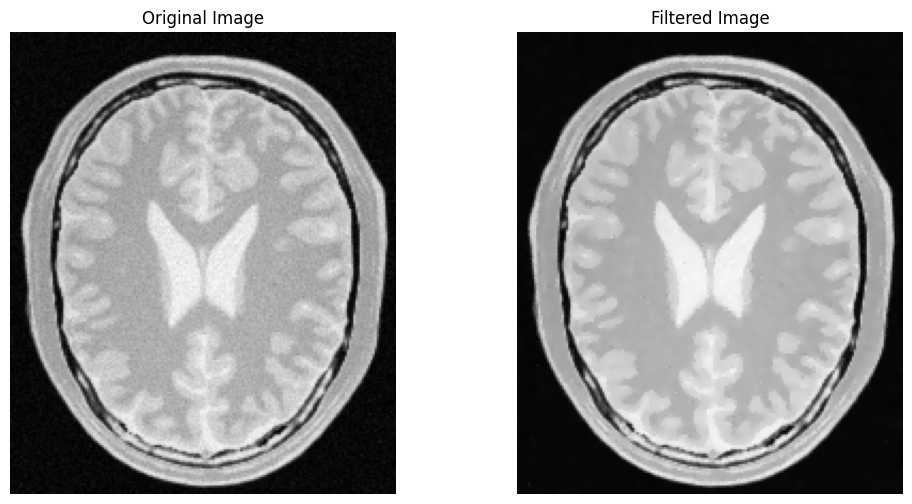

In [ ]:
InputPixelType = itk.F
OutputPixelType = itk.F
Dimension = 2

InputImageType = itk.Image[InputPixelType, Dimension]
OutputImageType = itk.Image[OutputPixelType, Dimension]

reader = itk.ImageFileReader[InputImageType].New()
reader.SetFileName(input_image)

FilterType = itk.GradientAnisotropicDiffusionImageFilter[InputImageType, OutputImageType]

filter = FilterType.New()
filter.SetInput(reader.GetOutput())
filter.SetConductanceParameter(0.3)
filter.SetNumberOfIterations(5)
filter.SetTimeStep(0.25)

filter.Update()

display_images(reader.GetOutput(), filter.GetOutput())


## Curvature Anisotropic Diffusion

itk::CurvatureAnisotropicDiffusionImageFilter does not enhance edges in the same way as classic anisotropic diffusion. It avoids the potential "negative" diffusion effect. Instead, MCDE ensures that diffusion is always "positive," meaning that the process will always lead to a smoothing effect without artificially increasing edge contrast.

- Preserves finer detailed structures in images
- There is a potential speed trade-off 

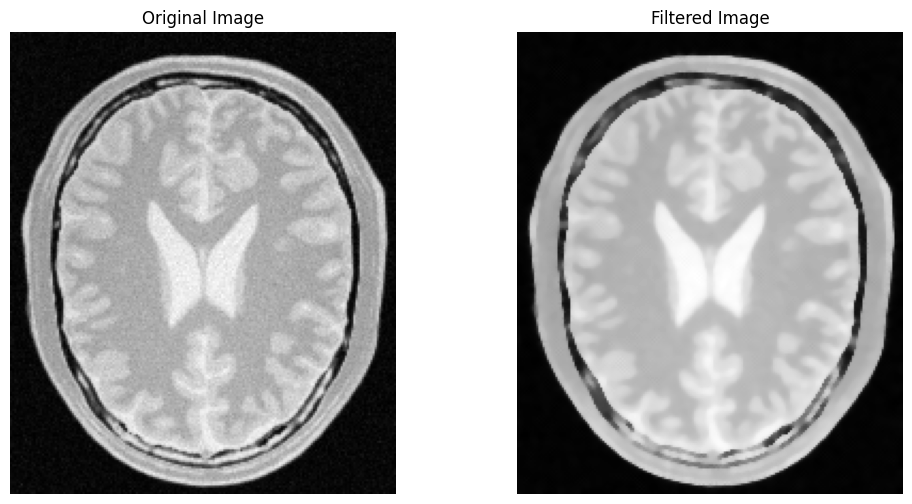

In [ ]:
# itkCurvatureAnisotropicDiffusionImageFilter

InputPixelType = itk.F
OutputPixelType = itk.F
Dimension = 2

InputImageType = itk.Image[InputPixelType, Dimension]
OutputImageType = itk.Image[OutputPixelType, Dimension]

reader = itk.ImageFileReader[InputImageType].New()
reader.SetFileName(input_image)

FilterType = itk.CurvatureAnisotropicDiffusionImageFilter[InputImageType, OutputImageType]

filter = FilterType.New()
filter.SetInput(reader.GetOutput())
filter.SetConductanceParameter(3) #typical value 
filter.SetNumberOfIterations(5) #typical value 
filter.SetTimeStep(0.125) #typical value

filter.Update()

display_images(reader.GetOutput(), filter.GetOutput())


## Curvature Flow

Performs edge-preserving smoothing in a similar fashion to the classical anisotropic diffusion. The filter uses a level set formulation where the iso-intensity contours in an image are viewed as level sets, where pixels of a particular intensity form one level set. 

The level set function is then evolved under the control of a diffusion equation where the speed is proportional to the curvature of the contour:


 Edge-preserving behavior is not guaranteed by this filter.
 Some degradation will occur on the edges and will increase as the number of iterations is increased.

Curvature (𝜅):

High Curvature: Areas with high curvature are regions where the iso-intensity contours are tightly curved, such as around small noise artifacts. These areas will diffuse (smooth) more quickly, which helps to remove small, jagged noise.

Low Curvature: Areas with low curvature are smoother and correspond to larger, more gradual changes in intensity. These regions will evolve more slowly, which helps to preserve the sharp boundaries of significant features in the image, such as the edges of objects.

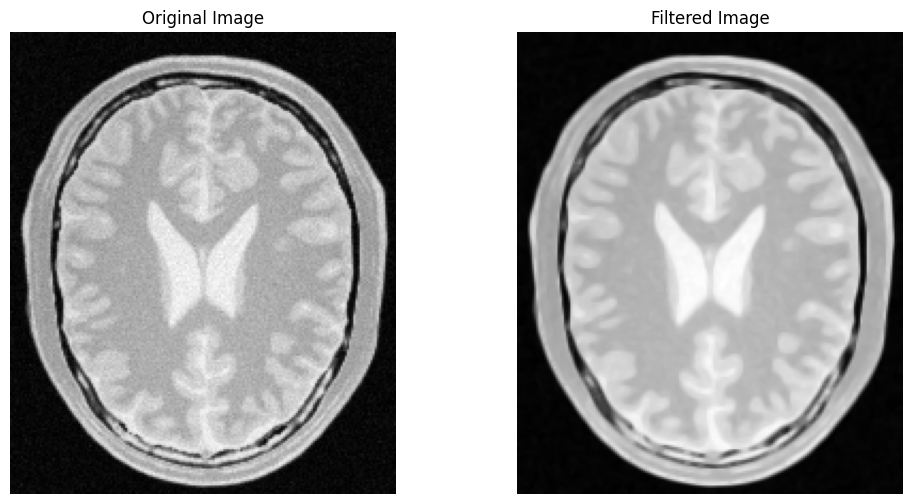

In [ ]:
#  CurvatureFlowImageFilter

InputPixelType = itk.F
OutputPixelType = itk.F
Dimension = 2

InputImageType = itk.Image[InputPixelType, Dimension]
OutputImageType = itk.Image[OutputPixelType, Dimension]

reader = itk.ImageFileReader[InputImageType].New()
reader.SetFileName(input_image)

FilterType = itk.CurvatureFlowImageFilter[InputImageType, OutputImageType]

filter = FilterType.New()
filter.SetInput(reader.GetOutput())
filter.SetNumberOfIterations(10) #typical value
filter.SetTimeStep(0.125)

filter.Update()

display_images(reader.GetOutput(), filter.GetOutput())


## MinMaxCurvature Flow

F=max(κ,0) → This means that diffusion is turned on only in areas where the curvature is positive, i.e., where the local intensity curve is concave. This causes small dark regions in a predominantly light area to shrink, which is useful for removing dark noise spots.

F=min(κ,0) → This applies diffusion where the curvature is negative, i.e., where the local intensity curve is convex. This causes light regions in a predominantly dark area to shrink, useful for removing bright noise spots in darker regions.

This switching prevents the unwanted diffusion of the simple curvature flow method.

The average intensity is computed over a neighborhood of pixels around each target pixel, where the size of the neighborhood is determined by a radius chosen by the user. This radius is important because it governs the scale of noise to be removed.

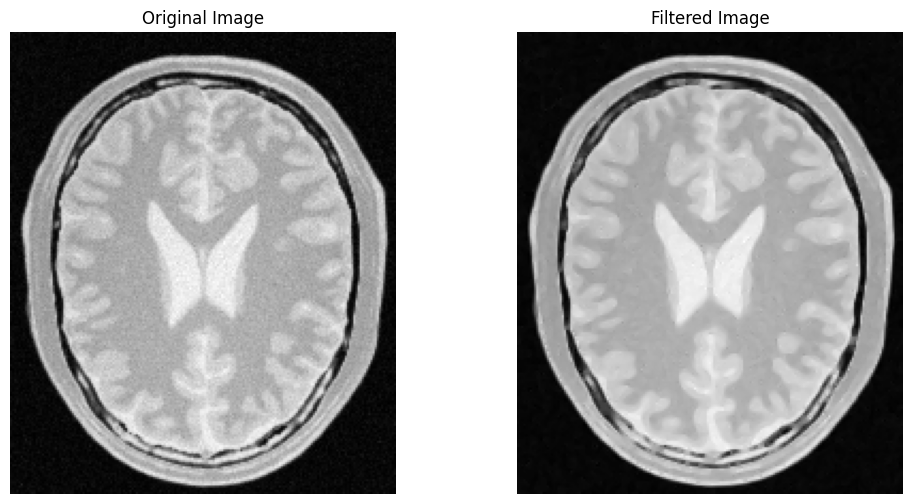

In [ ]:
# MinMaxCurvatureFlowImageFilter

InputPixelType = itk.F
OutputPixelType = itk.F
Dimension = 2

InputImageType = itk.Image[InputPixelType, Dimension]
OutputImageType = itk.Image[OutputPixelType, Dimension]

reader = itk.ImageFileReader[InputImageType].New()
reader.SetFileName(input_image)

FilterType = itk.MinMaxCurvatureFlowImageFilter[InputImageType, OutputImageType]

filter = FilterType.New()
filter.SetInput(reader.GetOutput()) 
filter.SetNumberOfIterations(10) #typical value
filter.SetTimeStep(0.125) #typical value
filter.SetStencilRadius(1) #typical value

filter.Update()

display_images(reader.GetOutput(), filter.GetOutput())

## Bilateral Filter

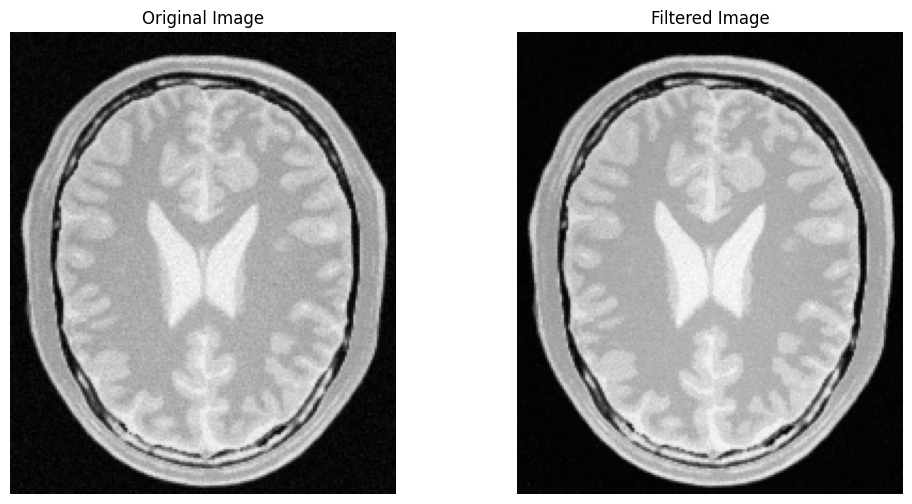

In [ ]:
#Bilateral Filter

InputPixelType = itk.F
OutputPixelType = itk.F
Dimension = 2

InputImageType = itk.Image[InputPixelType, Dimension]
OutputImageType = itk.Image[OutputPixelType, Dimension]

reader = itk.ImageFileReader[InputImageType].New()
reader.SetFileName(input_image)

FilterType = itk.BilateralImageFilter[InputImageType, OutputImageType]

filter = FilterType.New()
filter.SetInput(reader.GetOutput())

filter.SetDomainSigma(6)
filter.SetRangeSigma(5)

filter.Update()

display_images(reader.GetOutput(), filter.GetOutput())

In [ ]:
def display_image_with_vectors(original_image, vector_image):
    
    original_array = itk.array_from_image(original_image)
    vector_array = itk.array_from_image(vector_image)
    
    original_array = original_array.astype(np.uint8)
    
    # Prepare a figure with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot the original image
    axes[0].imshow(original_array, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Plot the vector field
    height, width, _ = vector_array.shape
    y, x = np.mgrid[0:height, 0:width]
    u = vector_array[:, :, 0]
    v = vector_array[:, :, 1]
    
    # Plot vector field

    axes[1].quiver(x, y, u, v, scale=10, color='gray', angles='xy', scale_units='xy')
    axes[1].set_title('Vector Field')
    axes[1].axis('off')

    plt.show()
    



# Edge Preserving Smoothing in Vector Images

##  Vector Gradient Anisotropic Diffusion

GradientRecursiveGaussianImageFilter, smoothes the image, then calculates gradient vectors. The VectorGradientAnisotropicDiffusionImageFilter, smoothes the image preserving the edges. 

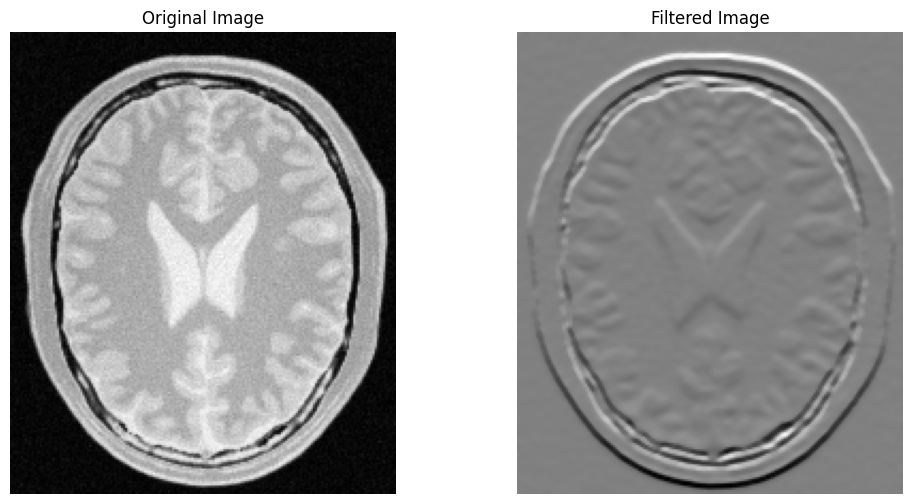

In [14]:
# itkVectorGradientAnisotropicDiffusionImageFilter

InputPixelType = itk.F
VectorPixelType = itk.CovariantVector[InputPixelType, 2]

InputImageType = itk.Image[InputPixelType, 2]
VectorImageType = itk.Image[VectorPixelType, 2]

reader = itk.ImageFileReader[InputImageType].New()
reader.SetFileName(input_image)

FilterType = itk.VectorGradientAnisotropicDiffusionImageFilter[VectorImageType, VectorImageType]

filter = FilterType.New()

GradientFilterType = itk.GradientRecursiveGaussianImageFilter[InputImageType, VectorImageType]
gradient_filter = GradientFilterType.New()
gradient_filter.SetInput(reader.GetOutput())

gradient_filter.Update()

filter.SetInput(gradient_filter.GetOutput())

filter.SetConductanceParameter(1) 
filter.SetNumberOfIterations(5) #typical value
filter.SetTimeStep(0.125) #typical value

filter.Update()

OutputPixelType = itk.F
OutputImageType = itk.Image[OutputPixelType, 2]

ComponentFilterType = itk.VectorIndexSelectionCastImageFilter[VectorImageType, OutputImageType]
component = ComponentFilterType.New()

component.SetIndex(1)

WritePixelType = itk.UC  # Unsigned char
WriteImageType = itk.Image[WritePixelType, 2]

RescaleFilterType = itk.RescaleIntensityImageFilter[OutputImageType, WriteImageType]
rescaler = RescaleFilterType.New()
rescaler.SetOutputMinimum(0)
rescaler.SetOutputMaximum(255)

# Process and save the component of the original gradient
component.SetInput(filter.GetOutput())
rescaler.SetInput(component.GetOutput())

component.Update()
rescaler.Update()

display_images(reader.GetOutput(), rescaler.GetOutput())


In [ ]:
print(itk.GradientImageFilter.GetTypes())


<itkTemplate itk::GradientImageFilter>
Options:
  [<class 'itk.itkImagePython.itkImageD2'>, <itkCType float>, <itkCType float>]
  [<class 'itk.itkImagePython.itkImageD3'>, <itkCType float>, <itkCType float>]
  [<class 'itk.itkImagePython.itkImageD4'>, <itkCType float>, <itkCType float>]
  [<class 'itk.itkImagePython.itkImageF2'>, <itkCType float>, <itkCType float>]
  [<class 'itk.itkImagePython.itkImageF3'>, <itkCType float>, <itkCType float>]
  [<class 'itk.itkImagePython.itkImageF4'>, <itkCType float>, <itkCType float>]
  [<class 'itk.itkImagePython.itkImageSS2'>, <itkCType float>, <itkCType float>]
  [<class 'itk.itkImagePython.itkImageSS3'>, <itkCType float>, <itkCType float>]
  [<class 'itk.itkImagePython.itkImageSS4'>, <itkCType float>, <itkCType float>]
  [<class 'itk.itkImagePython.itkImageUC2'>, <itkCType float>, <itkCType float>]
  [<class 'itk.itkImagePython.itkImageUC3'>, <itkCType float>, <itkCType float>]
  [<class 'itk.itkImagePython.itkImageUC4'>, <itkCType float>, <itk

## Vector Curvature Anisotropic Diffusion

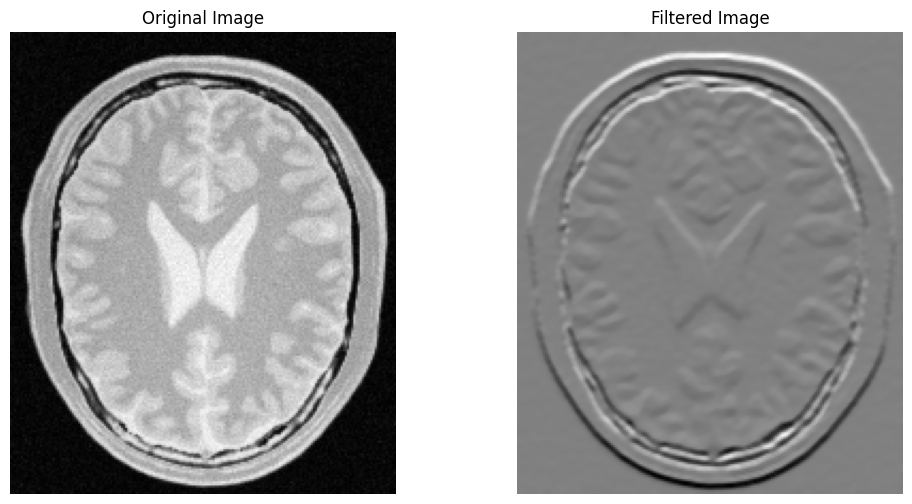

In [15]:
# itkVectorGradientAnisotropicDiffusionImageFilter

InputPixelType = itk.F
VectorPixelType = itk.CovariantVector[InputPixelType, 2]

InputImageType = itk.Image[InputPixelType, 2]
VectorImageType = itk.Image[VectorPixelType, 2]

reader = itk.ImageFileReader[InputImageType].New()
reader.SetFileName(input_image)

FilterType = itk.VectorCurvatureAnisotropicDiffusionImageFilter[VectorImageType, VectorImageType]

filter = FilterType.New()

GradientFilterType = itk.GradientRecursiveGaussianImageFilter[InputImageType, VectorImageType]
gradient_filter = GradientFilterType.New()
gradient_filter.SetInput(reader.GetOutput())

gradient_filter.Update()

filter.SetInput(gradient_filter.GetOutput())

filter.SetConductanceParameter(1) 
filter.SetNumberOfIterations(5) #typical value
filter.SetTimeStep(0.125) #typical value

filter.Update()

OutputPixelType = itk.F
OutputImageType = itk.Image[OutputPixelType, 2]

ComponentFilterType = itk.VectorIndexSelectionCastImageFilter[VectorImageType, OutputImageType]
component = ComponentFilterType.New()

component.SetIndex(1)

WritePixelType = itk.UC  # Unsigned char
WriteImageType = itk.Image[WritePixelType, 2]

RescaleFilterType = itk.RescaleIntensityImageFilter[OutputImageType, WriteImageType]
rescaler = RescaleFilterType.New()
rescaler.SetOutputMinimum(0)
rescaler.SetOutputMaximum(255)


# Process and save the component of the original gradient
component.SetInput(filter.GetOutput())
rescaler.SetInput(component.GetOutput())

component.Update()
rescaler.Update()


display_images(reader.GetOutput(), rescaler.GetOutput())